In [1]:
#Importation des bibilotèques python

%matplotlib inline
from os import listdir, chdir, getcwd
from os.path import isfile, join, abspath
from sorcery import dict_of

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from scipy.optimize import curve_fit



In [44]:
# Fichiers est une liste contenant le nom de tout les fichier de données

fichiers = [f for f in listdir("Dataset") if isfile(join("Dataset", f))]


# Création d'une liste de données (data). Chaque élément de la liste (data[i]) est un fichier NETCDF4 

data = []

for i in range(len(fichiers)) :
    data.append(nc.Dataset('Dataset/' + fichiers[i]))
    
    
# Au choix, une ville 
ville = data[10]


In [45]:
# Création des variables contenant les grandeurs d'interet 

second = ville.variables['time'][:]
day = ville.variables['day'][:]
year = ville.variables['year'][:]
xco2 = ville.variables['xco2'][:]
err_xco2 = ville.variables['xco2_error'][:]
flag_xco2 = ville.variables['extrapolation_flags_ak_xco2'][:]
hour = ville.variables['hour'][:]
month = ville.variables['day'][:]*0       # Le mois de l'année sera défini plus loin, il est juste mis à zero
day_cumul = ville.variables['day'][:]*0   # Calculé ensuite 


# Création d'une dataframe pandas. Chaque clé du dico correpond à une colonne
df = pd.DataFrame(dict_of(second,day,year,xco2,err_xco2,flag_xco2))



In [46]:
#Ajout du mois de l'année dans la colonne month

# Définir une fonction qui prend le numéro du jour de l'année en entrée et renvoie le mois correspondant
def day_to_month(num_jour):
    jours_par_mois = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    jours_ecoules = 0
    for mois in range(12):
        jours_ecoules += jours_par_mois[mois]
        if jours_ecoules >= num_jour:
            return int(mois + 1)

# Appliquer la fonction à chaque valeur de la colonne "jour_de_l_annee" pour créer une nouvelle colonne "mois_de_l_annee"
df['month'] = df['day'].apply(day_to_month)

# Ajout du jour cumulé dans la colonne jour_cumul
df['day_cumul'] = 365 * df['year'] + a1['day']



In [47]:
# Filtrage des data en fonction du flag xco2
df = df[df['flag_xco2'] >= 0]


In [48]:
# Calcul des moyennes 

# Groupby permet de portionner la dataframe selon les valeurs des colonnes spécifiées
day_mean_xco2 = df.groupby(['year','day'])['xco2'].mean()   # Moyenne journaliere de xCO2 
day_std_xco2 = df.groupby(['year','day'])['xco2'].std()   # Standard deviation de cette moyenne 
day_count_measurement = df.groupby(['year','day'])['xco2'].count() # Nombre de mesure de dans la journée 

#Calcul de la moyenne annuelle
year_mean_xco2 = df.groupby(['year'])['xco2'].mean()   # Moyenne journaliere de xCO2 
year_std_xco2 = df.groupby(['year'])['xco2'].std()   # Standard deviation de cette moyenne 
year_count_measurement = df.groupby(['year'])['xco2'].count() # Nombre de mesure de dans la journée 



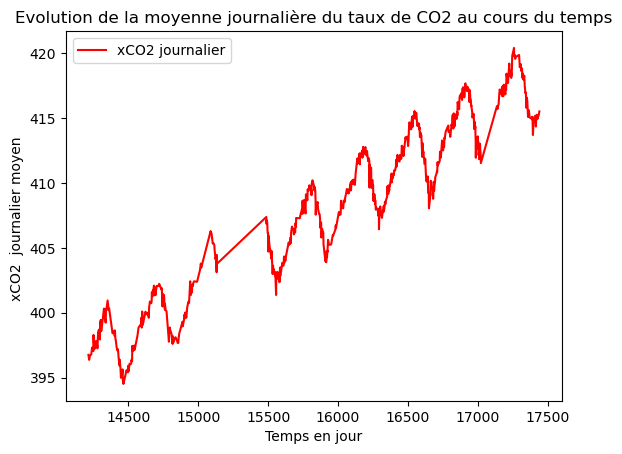

In [49]:
# Plot de la moyenne journalière de xCO2

x = df['day_cumul'].unique()
y = day_mean_xco2
yerr = day_std_xco2


# Créer un graphique avec x en fonction de y
plt.plot(x, y, 'r-', label='xCO2 journalier')
# Ajouter des barres d'erreur vertes à partir de yerr
#plt.errorbar(x, y, yerr=yerr, ecolor='g', capsize = 0.1,fmt = 'None')


plt.title('Evolution de la moyenne journalière du taux de CO2 au cours du temps')
plt.xlabel('Temps en jour')
plt.ylabel('xCO2  journalier moyen ')
plt.legend()

plt.show()


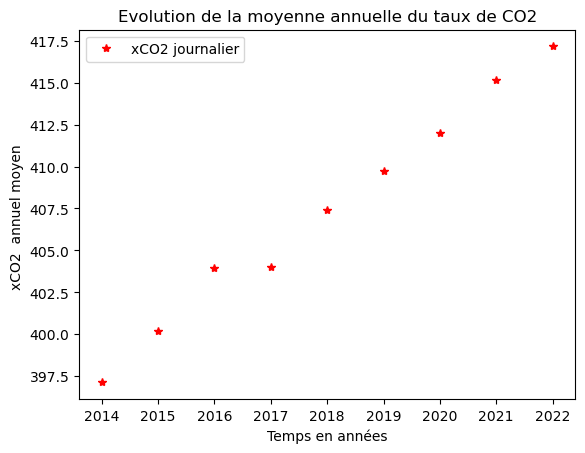

In [50]:
# Plot de la moyenne annuelle de xCO2

borne_mesure_valable = 100 ; # Souhaite afficher les points suffisemment moyennés  
x = df['year'].unique()
y = year_mean_xco2
yerr = year_std_xco2


# Créer un graphique avec x en fonction de y
plt.plot(x, y, 'r*', label='xCO2 journalier')
# Ajouter des barres d'erreur vertes à partir de yerr
#plt.errorbar(x, y, yerr=yerr, ecolor='g', capsize = 0.1,fmt = 'None')


plt.title('Evolution de la moyenne annuelle du taux de CO2')
plt.xlabel('Temps en années')
plt.ylabel('xCO2  annuel moyen ')
plt.legend()

plt.show()



A = 0.006682962130905281
B = 2.592376671147047
C = 0.017187425249734777
D = -26.175543089640495
E = 301.39512859020954


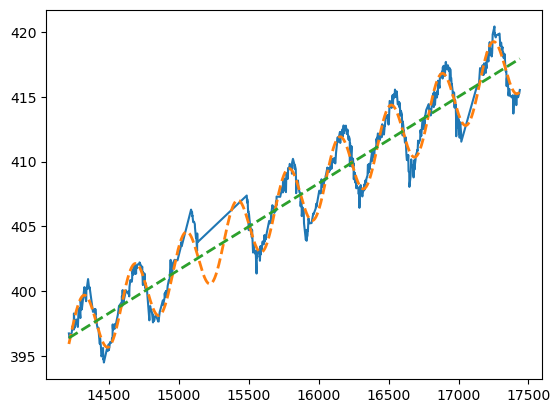

In [52]:
# On fit l'evolution annuelle de xCO2 par une fonction
x = df['day_cumul'].unique()
y = day_mean_xco2
yerr = day_std_xco2


# La fonction du modèle
def func_fit_1(t, A, B, C,D,E):
    return A * t + B * np.cos(C * t + D)+ E



# Ajuster les paramètres du modèle aux données
guess = [10, 0.1, 2* np.pi/365, 0, 395]  # On donne au modèle un guess initial des paramètres, sinon il galère 
popt, pcov = curve_fit(func_fit_1,x , y,guess)
xfit = range(int(min(x)),int(max(x)),1)

# Afficher les paramètres A, B et C ajustés
print('A =', popt[0])
print('B =', popt[1])
print('C =', popt[2])
print('D =', popt[3])
print('E =', popt[4])

plt.plot(x,y)
plt.plot(xfit,func_fit_1(xfit,popt[0],popt[1] ,popt[2],popt[3],popt[4]),ls='--',lw=2)
plt.plot(x,popt[0]* x + popt[4],ls='--',lw = 2)


In [39]:
range(min(x),max(x))

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [21]:
# On met toute les villes dans une meme Dataframe

all_data = pd.DataFrame()

for i in range(len(data)) :

    ville = data[i]
    
    second = ville.variables['time'][:]
    day = ville.variables['day'][:]
    year = ville.variables['year'][:]
    xco2 = ville.variables['xco2'][:]
    err_xco2 = ville.variables['xco2_error'][:]
    flag_xco2 = ville.variables['extrapolation_flags_ak_xco2'][:]
    lat = ville.variables['lat']
    
    df_ville = pd.DataFrame(dict_of(second,day,year,xco2,err_xco2,flag_xco2))
    
    all_data = pd.concat([all_data, df_ville], axis = 0 )
    


In [35]:
for i in ville.variables:
    print(i)

time
prior_time
prior_altitude
ak_altitude
ak_pressure
ak_xco2
extrapolation_flags_ak_xco2
ak_xwco2
extrapolation_flags_ak_xwco2
ak_xlco2
extrapolation_flags_ak_xlco2
ak_xch4
extrapolation_flags_ak_xch4
ak_xhf
extrapolation_flags_ak_xhf
ak_xo2
extrapolation_flags_ak_xo2
ak_xn2o
extrapolation_flags_ak_xn2o
ak_xco
extrapolation_flags_ak_xco
ak_xh2o
extrapolation_flags_ak_xh2o
prior_temperature
prior_pressure
prior_density
prior_h2o
prior_co2
prior_n2o
prior_co
prior_ch4
prior_o2
prior_hf
prior_hdo
prior_gravity
prior_equivalent_latitude
prior_tropopause_altitude
prior_effective_latitude
prior_mid_tropospheric_potential_temperature
gfit_version
gsetup_version
year
day
hour
lat
long
zobs
zmin
solzen
azim
tout
pout
hout
sia
fvsi
wspd
wdir
xluft
xluft_error
xhf
xhf_error
xh2o
xh2o_error
xhdo
xhdo_error
xco
xco_error
xn2o
xn2o_error
xch4
xch4_error
xlco2_experimental
xlco2_error_experimental
xwco2_experimental
xwco2_error_experimental
xco2
xco2_error
ak_xhdo
extrapolation_flags_ak_xhdo
xco2_x

In [ ]:
# Idées et questions 

# Soustraire l'evolution anuelle  pour observer les cycles saisonniers 
# Faire moyenne glissante sur les années pour lisser 
# Ville / Pas ville 
# Hemisphere nord / Hemisphere sud 
# Amplitude saisonniere 
# Tendance d'évolution générale
# Amplitude quotidienne 




# C'est quoi prior ? c'est quoi ak ? 






In [53]:
#On calcul pour toute les villes les amplitudes de variation journaliere / saisonieres / annuelles

all_fit_param = pd.DataFrame()

for i in range(len(data)) : 
    ville = data[i] 
    
    second = ville.variables['time'][:]
    day = ville.variables['day'][:]
    year = ville.variables['year'][:]
    xco2 = ville.variables['xco2'][:]
    err_xco2 = ville.variables['xco2_error'][:]
    flag_xco2 = ville.variables['extrapolation_flags_ak_xco2'][:]
    hour = ville.variables['hour'][:]
    month = ville.variables['day'][:]*0       # Le mois de l'année sera défini plus loin, il est juste mis à zero
    day_cumul = ville.variables['day'][:]*0   # Calculé ensuite 
    
    # Création d'une dataframe pandas. Chaque clé du dico correpond à une colonne
    df = pd.DataFrame(dict_of(second,day,year,xco2,err_xco2,flag_xco2))
    # On ajoute le mois
    df['month'] = df['day'].apply(day_to_month)
    # On ajoute le jour cumulé dans la colonne jour_cumul
    df['day_cumul'] = 365 * df['year'] + a1['day']
    # On filtre le flag
    df = df[df['flag_xco2'] >= 0]
    
    # Calcul des moyennes 

    # Groupby permet de portionner la dataframe selon les valeurs des colonnes spécifiées
    day_mean_xco2 = df.groupby(['year','day'])['xco2'].mean()   # Moyenne journaliere de xCO2 
    day_std_xco2 = df.groupby(['year','day'])['xco2'].std()   # Standard deviation de cette moyenne 
    day_count_measurement = df.groupby(['year','day'])['xco2'].count() # Nombre de mesure de dans la journée 

    #Calcul de la moyenne annuelle
    year_mean_xco2 = df.groupby(['year'])['xco2'].mean()   # Moyenne journaliere de xCO2 
    year_std_xco2 = df.groupby(['year'])['xco2'].std()   # Standard deviation de cette moyenne 
    year_count_measurement = df.groupby(['year'])['xco2'].count() # Nombre de mesure de dans la journée 


    # On fit l'evolution annuelle de xCO2 par une fonction
    x = df['day_cumul'].unique()
    y = day_mean_xco2
    yerr = day_std_xco2
    

    # Ajuster les paramètres du modèle aux données
    guess = [10, 0.1, 365, 0, 395]  # On donne au modèle un guess initial des paramètres, sinon il galère 
    popt, pcov = curve_fit(func_fit_1,x , y,guess)
    xfit = range(min(x),max(x),1)

    

    
    # La fonction du modèle
def func_fit_1(t, A, B, C,D,E):
    return A * t + B * np.cos(C * t + D)+ E
    
    
    evol_globale = popt[0] 
    amplitude_saisoniere = popt[1] 

    
    # Afficher les paramètres A, B et C ajustés
    print('A =', popt[0])
    print('B =', popt[1])
    print('C =', popt[2])
    print('D =', popt[3])
    print('E =', popt[4])
    
    
    
    fit_param = pd.DataFrame(dict_of(evol_globale, amplitude_saisoniere))
    
    all_fit_data = pd.concat([all_fit_param, fit_param], axis = 0 )
    
    

    


ValueError: array must not contain infs or NaNs